# Training of our CNN Model with data from casia-pp.
Lakshminarayana, N.N., Narayan, N., Napp, N., Setlur, S. and Govindaraju, V., 2017, February. A discriminative spatio-temporal mapping of face for liveness detection. In 2017 IEEE International Conference on Identity, Security and Behavior Analysis (ISBA) (pp. 1-7). IEEE.

In [1]:
# %load_ext tensorboard
# !pip install wandb
!wandb login ************************************

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [3]:
casia = pd.read_csv('../input/casia-pp/MAPPED_CASIA_FASD.csv',header=None)
casia.head()

,0,1,2,3,4,5,6,7,8,9,...,4091,4092,4093,4094,4095,4096,4097,4098,4099,4100
0,2126.373953,1985.402994,1984.004887,2117.216289,2004.705703,1999.361851,1985.070389,1985.873890,1998.870845,2034.655597,...,807.263987,602.146044,389.683405,7195.843181,1769.367430,True,False,11,195,1
1,1984.667859,244.056531,2155.695578,1965.490921,2060.819729,2142.681407,2156.417783,2131.583770,2129.226000,2169.977724,...,329.590183,502.422853,3572.653904,18463.513690,740.019671,True,False,11,195,1
2,1740.610153,776.563624,2065.093000,2009.679875,1978.064765,1987.313729,1971.953897,1982.120621,1973.289206,1922.527455,...,177.738652,3267.529246,2052.925833,1798.871018,866.080728,True,False,11,195,1
3,1450.444588,8980.607454,1888.815379,1980.850582,1987.556210,1969.857022,1961.763179,1913.486780,1879.610763,1970.100045,...,420.912943,1001.174780,1809.786389,2076.037861,1728.640414,True,False,11,195,1
4,3210.498059,3000.588779,3199.578698,3191.791603,3118.379707,3164.628123,3282.846989,3141.044327,2906.146253,2735.290651,...,759.136487,489.595502,3653.844372,1861.133139,1976.948991,True,False,11,195,1


In [4]:
# %tensorboard --logdir logs

In [5]:
x = np.concatenate([casia.iloc[:,:-5].values]).reshape(-1,64,64,1)
y = np.concatenate([casia.iloc[:,-1].values])
is_train = np.concatenate([casia.iloc[:,-4].values])
person_id = np.concatenate([casia.iloc[:,-4].values])

print(x.shape)
print(y.shape)
print(is_train.shape)
print(person_id.shape)

(4202, 64, 64, 1)
(4202,)
(4202,)
(4202,)


In [6]:
from tensorflow.keras.utils import to_categorical
# y = (y==0).astype('int')
y = to_categorical(y)
y.sum(axis=0)

array([1007., 3195.], dtype=float32)

In [7]:
from sklearn.model_selection import train_test_split
# X_train = x[np.where(is_train)[0]]
# y_train = y[np.where(is_train)[0]]
# X_valid = X_train[val_idx]
# y_valid = y_train[val_idx]
# X_train = np.delete(X_train, val_idx, axis = 0)
# y_train = np.delete(y_train, val_idx, axis = 0)
# X_test = x[np.where(is_train == False)[0]]
# y_test = y[np.where(is_train == False)[0]]
# X_test = x[np.setdiff1d(np.arange(x.shape[0], dtype='int'), np.where(is_train)[0])]
# y_test = y[np.setdiff1d(np.arange(x.shape[0], dtype='int'), np.where(is_train)[0])]
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
X_train = x[is_train == True]
y_train = y[is_train == True]
X_test = x[is_train == False]
y_test = y[is_train == False]
print(X_train.shape)
print(y_train.shape)
# print(X_valid.shape)
# print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(1421, 64, 64, 1)
(1421, 2)
(2781, 64, 64, 1)
(2781, 2)


In [8]:
y_train.sum(axis=0)

array([ 376., 1045.], dtype=float32)

In [9]:
y_test.sum(axis=0)

array([ 631., 2150.], dtype=float32)

In [10]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Grad_Project_Liveness_Model", entity="gp_fcaicu")

wandb: Currently logged in as: ahmed-rushdi (gp_fcaicu). Use `wandb login --relogin` to force relogin


In [11]:
BATCH_SIZE = 16
EPOCHS = 300
LR = 0.01
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    fill_mode='reflect',
    horizontal_flip=True,
#     preprocessing_function = tf.keras.applications.vgg16.preprocess_input 
)

lr_red = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=50,
    verbose=1,
    mode='max',
    min_lr=1e-5,
#     min_delta=0.1
)
# def scheduler(epoch, lr):
#     if (epoch+1) % 10:
#         return lr
#     else:
#         return lr * 0.1

# model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
# round(model.optimizer.lr.numpy(), 5)

checkpoint_filepath = 'bestmodel'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)
# aug.fit(X_train)

In [13]:
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}

2022-07-17 01:56:20.855974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 01:56:20.976153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 01:56:20.976974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 01:56:20.978615: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0

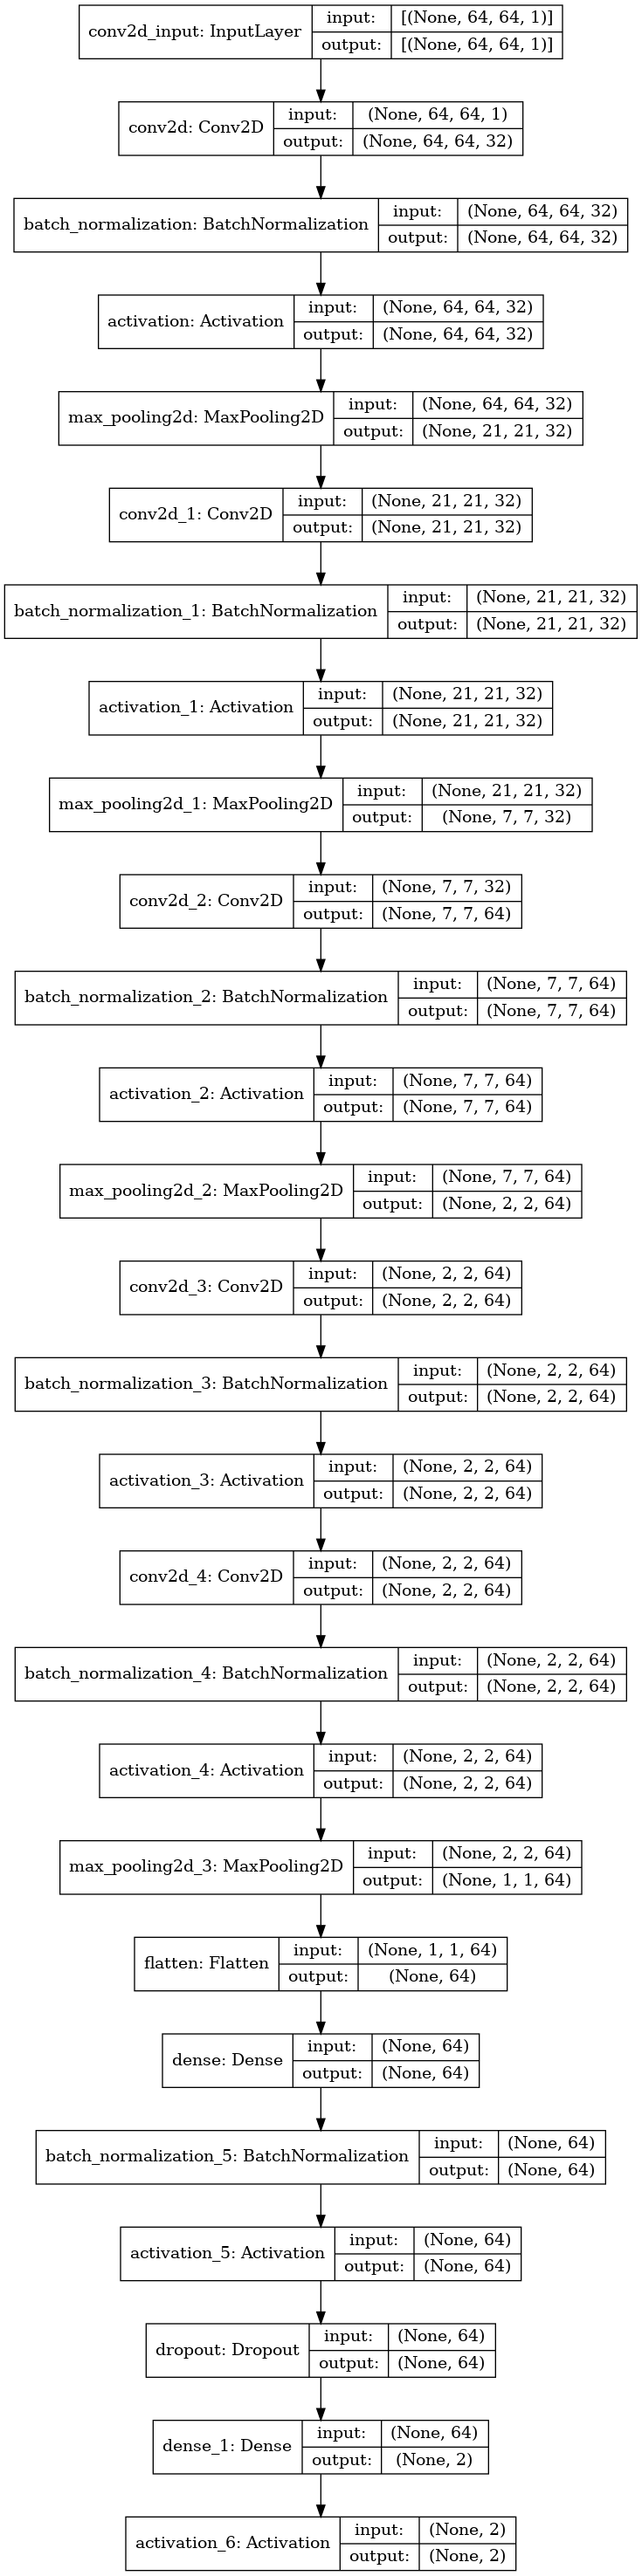

In [14]:
from keras.layers import *
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(64,64,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))


model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation("softmax"))
model.summary()
keras.utils.plot_model(model, show_shapes=True,)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=LR,momentum=0.9), metrics= ['accuracy'])

In [16]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [17]:
model.fit(aug.flow(X_train, y_train, batch_size = BATCH_SIZE),
          validation_data = (X_test, y_test),
          epochs=EPOCHS,
          callbacks=[
              lr_red, 
              model_checkpoint_callback,
              WandbCallback()
          ]
          )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-07-17 01:56:25.582799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-07-17 01:56:27.448684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


89/89 [==============================] - 10s 20ms/step - loss: 0.6191 - accuracy: 0.6875 - val_loss: 0.9888 - val_accuracy: 0.7731

Epoch 00001: val_accuracy improved from -inf to 0.77310, saving model to bestmodel
Epoch 2/300
89/89 [==============================] - 1s 14ms/step - loss: 0.5172 - accuracy: 0.7072 - val_loss: 0.4644 - val_accuracy: 0.7731

Epoch 00002: val_accuracy did not improve from 0.77310
Epoch 3/300
89/89 [==============================] - 1s 13ms/step - loss: 0.4978 - accuracy: 0.7157 - val_loss: 0.4613 - val_accuracy: 0.6951

Epoch 00003: val_accuracy did not improve from 0.77310
Epoch 4/300
89/89 [==============================] - 1s 13ms/step - loss: 0.3939 - accuracy: 0.8030 - val_loss: 0.6432 - val_accuracy: 0.6397

Epoch 00004: val_accuracy did not improve from 0.77310
Epoch 5/300
89/89 [==============================] - 1s 13ms/step - loss: 0.3485 - accuracy: 0.8642 - val_loss: 0.5023 - val_accuracy: 0.7684

Epoch 00005: val_accuracy did not improve from 0

In [18]:
model.load_weights(checkpoint_filepath)
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)
model.fit(aug.flow(X_train, y_train, batch_size = BATCH_SIZE),
          validation_data = (X_test, y_test),
          epochs=EPOCHS,
          callbacks=[
#               lr_red, 
              model_checkpoint_callback,
              WandbCallback()
          ]
          )
model.load_weights(checkpoint_filepath)
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00005)
model.fit(aug.flow(X_train, y_train, batch_size = BATCH_SIZE),
          validation_data = (X_test, y_test),
          epochs=EPOCHS,
          callbacks=[
#               lr_red, 
              model_checkpoint_callback,
              WandbCallback()
          ]
          )
model.load_weights(checkpoint_filepath)
model.save('my_model.h5')

Epoch 1/300
89/89 [==============================] - 1s 15ms/step - loss: 0.0919 - accuracy: 0.9690 - val_loss: 0.6337 - val_accuracy: 0.8026

Epoch 00001: val_accuracy did not improve from 0.84466
Epoch 2/300
89/89 [==============================] - 1s 13ms/step - loss: 0.0757 - accuracy: 0.9740 - val_loss: 0.6655 - val_accuracy: 0.7918

Epoch 00002: val_accuracy did not improve from 0.84466
Epoch 3/300
89/89 [==============================] - 1s 13ms/step - loss: 0.0576 - accuracy: 0.9838 - val_loss: 0.6631 - val_accuracy: 0.7864

Epoch 00003: val_accuracy did not improve from 0.84466
Epoch 4/300
89/89 [==============================] - 1s 13ms/step - loss: 0.0556 - accuracy: 0.9789 - val_loss: 0.6559 - val_accuracy: 0.7843

Epoch 00004: val_accuracy did not improve from 0.84466
Epoch 5/300
89/89 [==============================] - 2s 21ms/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 0.6566 - val_accuracy: 0.7832

Epoch 00005: val_accuracy did not improve from 0.84466
Epoch 6/30

In [19]:
y_p = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis= 1), y_p.argmax(axis= 1)))

              precision    recall  f1-score   support

           0       0.72      0.51      0.60       631
           1       0.87      0.94      0.90      2150

    accuracy                           0.84      2781
   macro avg       0.79      0.73      0.75      2781
weighted avg       0.84      0.84      0.83      2781



In [20]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.01


In [21]:
wandb.log({"classification_report": classification_report})
wandb.finish()

accuracy,▁▆▇▇█████████▆█▇▇▇▇█▇▇█████▆▇▇▇▇▇▇▇█▇▇▇▇
epoch,▁▁▂▃▃▄▄▅▅▆▆▇█▁▁▂▃▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▃▂▂▂▂▂▂▂▂
lr,███████████▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇▆██▇▇▇▇▇▇▇▆▆▇▇▇▆▇▇▇▇▇▇▇▇▆▇▆▇▇▇▇▆▇▇▆▇▇
val_loss,▅▃▇▄▄▆▇▇█████▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂
accuracy,0.99437
best_epoch,9
best_val_loss,0.45816
classification_report,sklearn.metrics._cla...
epoch,299
